# Predicting Thoracic Pathologies 

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import tensorflow as tf
sns.set()

## Dataset

Our dataset is located at [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315). The dataset was originally created based on [this publication](https://nihcc.app.box.com/v/ChestXray-NIHCC/file/256057377774). This chest X-ray database (CXR8) was constructed due to addressing a need for hospital-scale radiological imaging presenting realistic clinical and methodological challenges, and present a public database for uses in disease analyses.

First, we can take a look at details of our patient data by checking the Data Entry csv file showing general characteristics of each subject's image. Most importantly we will see the finding labels, which are generated via NLP from radiologist reports. We can also see more details including patient age/sex, the view position of the image (i.e. Posterior-Anterior), and the original image's dimensions. 

In [2]:
patient_data = pd.read_csv("../Data_Entry_2017_v2020.csv")
patient_data.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [3]:
patient_data['Finding Labels'].head(5)

0              Cardiomegaly
1    Cardiomegaly|Emphysema
2     Cardiomegaly|Effusion
3                No Finding
4                    Hernia
Name: Finding Labels, dtype: object

In [4]:
patient_data['Patient ID'].tail(1)

112119    30805
Name: Patient ID, dtype: int64

Our patient data totals to 112,120 total medical images for 30,805 unique patients. These images have been collected from patients spanning 1992 - 2015 from the clinical PACS database at NIHCC (National Institutes of Health Clinical Center) in which image labels are mined via NLP from radiology reports. The text-mined disease labels are expectedly >90% accuracy. Images are labeled as XXX_YYY.png, where XXX represents patient ID and YYY represents the CXR ID (or followup) of that patient.

Our finding labels include a total of 14 of the most common thoracic pathologies:

Atelectasis, Cardiomegaly, Effusion, Infiltration, Mass, Nodule, Penumonia, Penumothorax, Consolidation, Edema, Emphysema, Fibrosis, Pleural Thickening, and Hernia.

Using our first patient (57M) as an example, we can see their first CXR (00000001_000.png) which is labeled with cardiomegaly. 

<img src="../images/00000001_000.png" alt="U-net Image" width="300" align="middle"/>


## Considerations

We want to make sure that our machine learning model(s) recognize specific features and pathologies, rather than simply memorize patient-specific attributes. To ensure this, while splitting our dataset into training, testing, and validation sets we will make sure our all of the images of each patient belong to a single set (i.e. no patient should have one image in a training set and another image in a validation or testing set). 

This data is already divided accordingly to text files test_list.txt and train_val_list.txt associated with the CXR8 dataset as recommended by the authors. Using a structured split dataset as referenced by [a publication analyzing pruning impact on medical image classifiers](https://arxiv.org/pdf/2308.09180), we have three labeled datasets respecting the patient division structured with one-hot-encoded columns representing pathologies.

Each set also contains a column for Subject ID, Image ID, and for No Findings (i.e. none of the 14 pathologies show up). Before we explore the training set in particular to assess data distribution, summaries, and structure we make sure to remove the disease features outside the 14 pathologies being focused on. 


In [5]:
# Patient training data
# Removing unneeded pathologies from training, validation, and test sets

pt_train = pd.read_csv("miccai2023_nih-cxr-lt_labels_train.csv")
pt_train = pt_train.drop(columns=['Pneumoperitoneum', 
                                  'Pneumoperitoneum',
                                  'Pneumomediastinum', 
                                  'Subcutaneous Emphysema',
                                  'Tortuous Aorta', 
                                  'Calcification of the Aorta'],
                        axis = 0)
pt_valid = pd.read_csv("miccai2023_nih-cxr-lt_labels_val.csv").drop(columns=['Pneumoperitoneum', 
                                  'Pneumoperitoneum',
                                  'Pneumomediastinum', 
                                  'Subcutaneous Emphysema',
                                  'Tortuous Aorta', 
                                  'Calcification of the Aorta'],
                        axis = 0)
pt_test = pd.read_csv("miccai2023_nih-cxr-lt_labels_test.csv").drop(columns=['Pneumoperitoneum', 
                                  'Pneumoperitoneum',
                                  'Pneumomediastinum', 
                                  'Subcutaneous Emphysema',
                                  'Tortuous Aorta', 
                                  'Calcification of the Aorta'],
                        axis = 0)
pt_train.head()

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural Thickening,Pneumonia,Pneumothorax,No Finding,subj_id
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
4,00000004_000.png,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,4


## Exploratory Data Analysis

In [6]:
pt_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78506 entries, 0 to 78505
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  78506 non-null  object
 1   Atelectasis         78506 non-null  int64 
 2   Cardiomegaly        78506 non-null  int64 
 3   Consolidation       78506 non-null  int64 
 4   Edema               78506 non-null  int64 
 5   Effusion            78506 non-null  int64 
 6   Emphysema           78506 non-null  int64 
 7   Fibrosis            78506 non-null  int64 
 8   Hernia              78506 non-null  int64 
 9   Infiltration        78506 non-null  int64 
 10  Mass                78506 non-null  int64 
 11  Nodule              78506 non-null  int64 
 12  Pleural Thickening  78506 non-null  int64 
 13  Pneumonia           78506 non-null  int64 
 14  Pneumothorax        78506 non-null  int64 
 15  No Finding          78506 non-null  int64 
 16  subj_id             78

In [7]:
pathology_cols = list(pt_train.drop(['id','subj_id'], axis = 1).keys())
pathology_cols # deliberately including 'No Findings' as a pathology column

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural Thickening',
 'Pneumonia',
 'Pneumothorax',
 'No Finding']

We can see that there are no null values in our dataset, and that our data types are standardized (one-hot-encoded as binary int64 values).

Now we'll focus on the class distributions for each type of pathology.

The class Atelectasis has 7587 samples
The class Cardiomegaly has 1590 samples
The class Consolidation has 2626 samples
The class Edema has 1283 samples
The class Effusion has 7919 samples
The class Emphysema has 1327 samples
The class Fibrosis has 1138 samples
The class Hernia has 130 samples
The class Infiltration has 12739 samples
The class Mass has 3689 samples
The class Nodule has 4359 samples
The class Pleural Thickening has 1998 samples
The class Pneumonia has 806 samples
The class Pneumothorax has 2432 samples
The class No Finding has 44625 samples


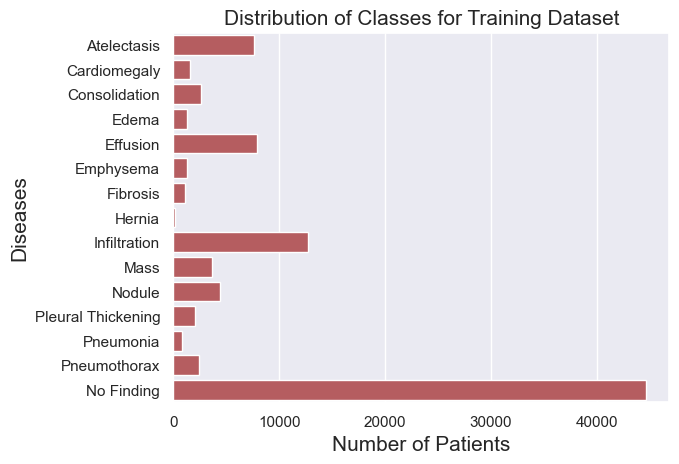

In [8]:
# Count up the number of instances of each class (drop non-class columns from the counts)
class_counts = pt_train.sum().drop(['id','subj_id'])

for column in class_counts.keys():
    print(f"The class {column} has {pt_train[column].sum()} samples")

# Plotting pathology count distributions
sns.barplot(x = class_counts.values, y = class_counts.index, color='r')
plt.title('Distribution of Classes for Training Dataset', fontsize=15)
plt.xlabel('Number of Patients', fontsize=15)
plt.ylabel('Diseases', fontsize=15)
plt.show()

Based on these distributions, it is clear that we have a significantly imbalanced dataset showing a majority of images presenting with no findings. We can also see that hernias are the least represented pathology with only 130 total samples. Turning to literature, we can see that the [following publication](https://arxiv.org/pdf/2208.13365) addresses clinical data imbalances. In particular, it discusses possible avenues to address the distribution imbalance with majority of patients present without any of the 14 indicated pathologies.

### Ensuring no patient overlap

As mentioned previously, we do not want patient overlap--this way, our model is trained on specific pathological features rather than specific patient features. We can check for overlap between our training, validation and test sets:

In [9]:
ids_train_set = set(pt_train.subj_id.values)
ids_valid_set = set(pt_valid.subj_id.values)
ids_test_set = set(pt_test.subj_id.values)
patient_overlap = list(ids_train_set.intersection(ids_valid_set))
patient_overlap_test = list(ids_test_set.intersection(ids_valid_set))
n_overlap = len(patient_overlap)
n_overlap_test = len(patient_overlap_test)
print(f'There are {n_overlap} Patient IDs in both the training and validation sets')
print(f'There are {n_overlap_test} Patient IDs in both the validation and test sets')

There are 0 Patient IDs in both the training and validation sets
There are 0 Patient IDs in both the validation and test sets


## Image Preprocessing

We need to process images for our convolutional neural networks to train more effectively. The images should be normalized and scaled for the CNN to converge faster. Moreover, our limited dataset size (especially for representation on less common pathologies like hernias) can be effectively increased by data augmentation to reduce chances of overfitting. However, we do need to keep in mind that not all augmentation is appropriate--for example, flipping an image (across the Y axis) would place the heart on the wrong side of the patient, which would represent incorrect anatomy for our network to be trained on. 

Generally speaking, properly preprocessed images should help highlight our essential features while minimizing less relevant ones (ie related to noise, extreme brightness, etc). We start by looking at our first image in greater depth:

### Checking one CXR 

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.5025 and the standard deviation is 0.2644


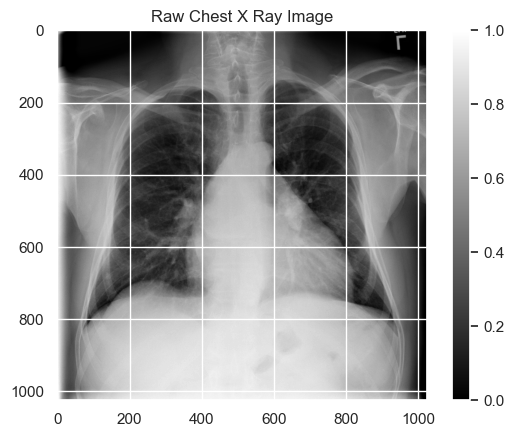

In [10]:
# Looking at first raw image in depth
img_dir = '../images'
sample_img = pt_train.id[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

Our images are largely 1024 x 1024 in size, but we don't have standardized mean/StD values for pixel intensity. We can create a list of file paths and multi-hot label vectors, incorporate a tf.data.Dataset using `from_tensor_slices` and map out each image to perform per-image normalization. We can batch and prefetch the dataset for performance.

In [11]:
image_files = pt_train['id'].values
labels = pt_train[pathology_cols].values
dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
# gives us .png + label pairs

2025-02-24 19:11:35.087726: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-24 19:11:35.087757: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-24 19:11:35.087761: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1740442295.088045 28670165 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1740442295.088489 28670165 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
IMG_SIZE = (224, 224)
# DenseNet121 designed for ImageNet images of size 224x224, so we reduce our original sizes to this

def load_and_preprocess_image(filename, label):
    full_path = tf.strings.join([img_dir, filename], separator=os.path.sep)
    image_bytes = tf.io.read_file(full_path)
    image = tf.io.decode_image(image_bytes, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)
    # normalization: mean=0, std=1
    mean, var = tf.nn.moments(image, axes=[0, 1, 2])
    std = tf.sqrt(var)
    image = (image - mean) / tf.maximum(std, 1e-7) # avoid division by 0
    return image, label # returns normalized image + label

### Data Augmentation

We'll introduce very small random rotations, zooms, and brightness adjustments to give our smaller dataset a better chance in terms of generalization with our model.

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.1), # will alter the mean = 0 / std = 1 normalization
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.05), 
    # NO flipping to be safe
])

In [14]:
BATCH_SIZE = 128
# Smaller input images means bigger batches in GPU memory? 
# if run out of GPU memory, drop to 64/32

train_dataset = (
    dataset
    .shuffle(buffer_size=len(pt_train), reshuffle_each_iteration=True) # randomize order of pairs 
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # normalizes each image
    .map(lambda x, y: (data_augmentation(x, training=True), y),
       num_parallel_calls=tf.data.AUTOTUNE) # apply augments
    .batch(BATCH_SIZE) # grouping to 8 images/labels each
    .prefetch(tf.data.AUTOTUNE) # more efficient training
)
# we can iterate through dataset: for batch_images, batch_labels in train_dataset: ...
# or with a keras model, train on this dataset directly
# or manually fetch batches (below)

Now we can fetch batches and take a look at different images--though we standardized our mean to 0 and std to 1, our actual values differ due to the RandomContrast we applied during image augmentation.

2025-02-24 19:11:35.479132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1740442295.489847 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-24 19:11:35.948546: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_21}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-02-24 19:11:35.948597: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node sequential_1/random_zoom_1/Add/_18}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-02-24 19:11:35.948634: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3018082222174441760
2025-02-24 19:11:35.9489

Batch of images shape: (128, 224, 224, 3)
Batch of labels shape: (128, 15)
Sample image stats: mean=0.4189, std=0.4169


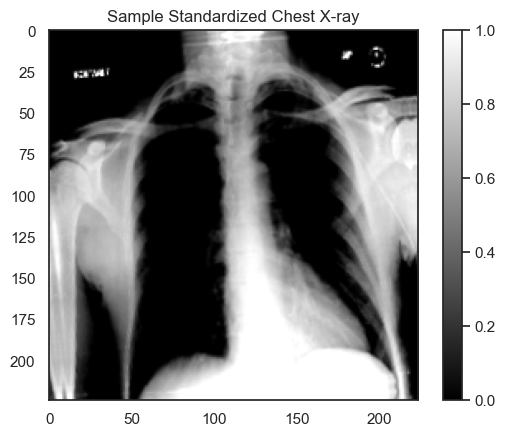

Corresponding label vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [15]:
# Fetch one batch
images_batch, labels_batch = next(iter(train_dataset))
print("Batch of images shape:", images_batch.shape)  # (8, 224, 224, 1)
print("Batch of labels shape:", labels_batch.shape)  # (8, 15)

# First image in this batch
sample_image = images_batch[0].numpy()
sample_label = labels_batch[0].numpy() 
print(f"Sample image stats: mean={sample_image.mean():.4f}, "
      f"std={sample_image.std():.4f}")
sns.set_style("white")
plt.imshow(sample_image.squeeze(), cmap="gray")
plt.colorbar()
plt.title("Sample Standardized Chest X-ray")
plt.show()
print("Corresponding label vector:", sample_label)

### Data Imbalance Considerations

As previously discussed, we need to account for data imbalances--particularly due to the fact that a significant majority of CXRs present with no findings. In order to create an effective model or CNN, we need to consider weighted loss functions to address this imbalance. We want to train our model with an evenly balanced dataset so positive and negative training cases are contributing equally to the loss. 

Using a normal cross-entropy loss function with an unbalanced dataset (like the one we have) results in more prioritization in the majority class (ie negative here) as it contributes more to the loss. 

One way to change this contribution inequality is multiplying each example from each class by class-specific weight factors so overall contribution of each class is the same.


In [16]:
def compute_class_freqs(labels):
    # pos/neg freq for each class given labels
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1.0 - positive_frequencies
    return positive_frequencies, negative_frequencies

In [17]:
freq_pos, freq_neg = compute_class_freqs(labels)
print("Positive frequencies:", freq_pos)
print("Negative frequencies:", freq_neg)

Positive frequencies: [0.09664229 0.02025323 0.03344967 0.0163427  0.10087127 0.01690317
 0.01449571 0.00165592 0.16226785 0.04699004 0.05552442 0.02545028
 0.01026673 0.03097852 0.56842789]
Negative frequencies: [0.90335771 0.97974677 0.96655033 0.9836573  0.89912873 0.98309683
 0.98550429 0.99834408 0.83773215 0.95300996 0.94447558 0.97454972
 0.98973327 0.96902148 0.43157211]


We can look at our positive vs negative contribution ratios per each pathology:

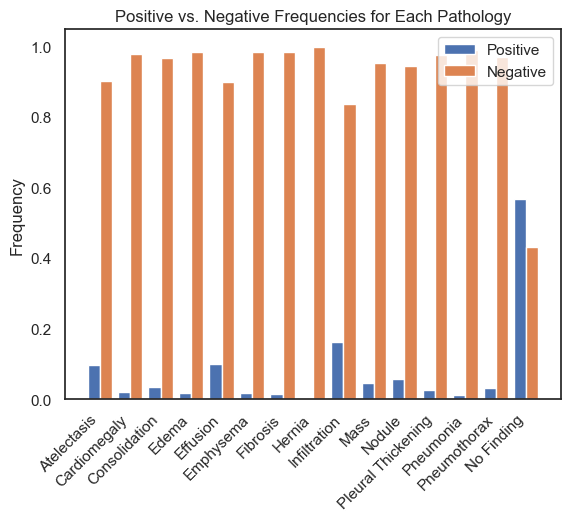

In [18]:
x = np.arange(len(pathology_cols))
bar_width = 0.4

# Plot pos frequencies
plt.bar(
    x - bar_width/2,        # Shift the bars to the left by half the bar width
    freq_pos,
    width=bar_width,
    label='Positive',
)

# Plot neg frequencies
plt.bar(
    x + bar_width/2,        # Shift the bars to the right by half the bar width
    freq_neg,
    width=bar_width,
    label='Negative',
)
plt.xticks(x, pathology_cols, rotation=45, ha='right')
plt.ylabel('Frequency')
plt.title('Positive vs. Negative Frequencies for Each Pathology')
plt.legend()

It's clear here that there's a significantly higher contribution by negative cases than positive cases, with the exception of No Finding (representing normal).

In [19]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

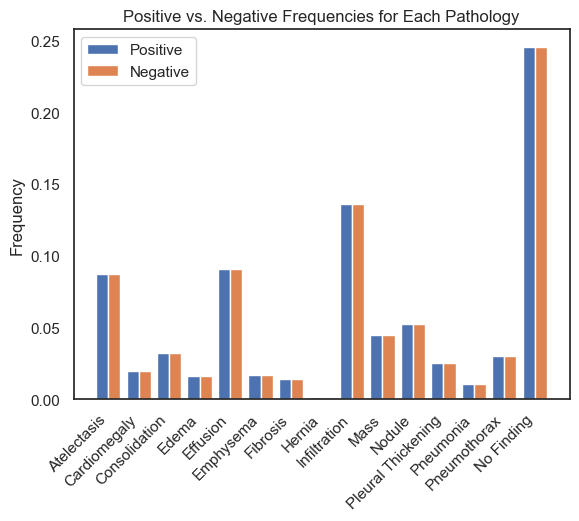

In [20]:
# Plot pos frequencies
plt.bar(
    x - bar_width/2,        # Shift the bars to the left by half the bar width
    pos_contribution,
    width=bar_width,
    label='Positive',
)

# Plot neg frequencies
plt.bar(
    x + bar_width/2,        # Shift the bars to the right by half the bar width
    neg_contribution,
    width=bar_width,
    label='Negative',
)
plt.xticks(x, pathology_cols, rotation=45, ha='right')
plt.ylabel('Frequency')
plt.title('Positive vs. Negative Frequencies for Each Pathology')
plt.legend()

We create our `get_weighted_loss` function that calculates weighted loss per batch--for multi-class loss, we add up average loss for each individual class. To avoid possible numerical errors (ie if predicted value is 0), we add a small value $\epsilon$ to predicted values prior to taking their log values.

Our weighted loss for each training case (without incorporating episilon) would be:

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [21]:
def get_weighted_loss(pos_weights, neg_weights, episilon = 1e-7):
    # return weighted loss function given pos/neg weights (arr for each class, size)
    def weighted_loss(y_true, y_pred):
        # return weighted loss value given tensors of true labels/predicted labels
        loss = 0.0
        for i in range(len(pos_weights)):
            pos_loss = -pos_weights[i] * y_true[:, i] * tf.math.log(y_pred[:, i] + episilon)
            neg_loss = -neg_weights[i] * (1.0 - y_true[:, i]) * tf.math.log(1.0 - y_pred[:, i] + episilon)
            loss += tf.math.reduce_mean(pos_loss + neg_loss)
        return loss
    return weighted_loss

Now we prepare our validation and test datasets with a `tf.data` pipeline, as we did with our training set. 

In [22]:
val_image_files = pt_valid['id'].values
val_labels = pt_valid[pathology_cols].values
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_files, val_labels))
val_dataset = (
    val_dataset
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [23]:
test_image_files = pt_test['id'].values
test_labels      = pt_test[pathology_cols].values
test_dataset     = tf.data.Dataset.from_tensor_slices((test_image_files, test_labels))
test_dataset = (
    test_dataset
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

We define callbacks in Keras like early stopping and creating an adaptive learning rate (LR scheduler) to fine tune the training of our model. Based on repos created from previous studies/publications related to use of DenseNet121 as a CNN to train on CXR data, we use the associated weights of `densenet.hdf5`. We train just the head first by freezing the entire DenseNet, then building a new head and compiling/training (with less epochs and a larger learning rate) before unfreezing the last 30 layers for fine-tuning (with more epochs and a smaller learning rate). 

We also add a cross-validation step in the process.

In [24]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

### Defining Keras Callbacks:

# LR Scheduler so LR adapts when validation loss plateaus
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,          # reduce LR by a factor of 10
    patience=1,        
    verbose=1
)

# Early Stopping when validation doesn't improve
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=1,          
    restore_best_weights=True
)

# cross-validation:

from sklearn.model_selection import GroupKFold

# k-fold CV: we need arrays, not tf.data.Datasets
X = pt_train['id'].values                       
y = pt_train[pathology_cols].values              
groups = pt_train['subj_id'].values               # to ensure same patient is only in one fold

n_splits = 2
gkf = GroupKFold(n_splits=n_splits)

def build_model(learning_rate=1e-3, freeze_base=True):
    # use pretrained weights
    base_model = DenseNet121(weights='densenet.hdf5', include_top=False)
    
    # freeze/unfreeze
    for layer in base_model.layers:
        layer.trainable = not freeze_base

    # build new head + compile w custom weighted loss
    x = GlobalAveragePooling2D()(base_model.output)
    predictions = Dense(len(pathology_cols), activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=get_weighted_loss(pos_weights, neg_weights)
    )
    return model

fold_val_losses = []

for fold_index, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
    print(f"Fold {fold_index} of {n_splits}")
    
    # TF build for this fold
    X_train_fold = X[train_idx]
    y_train_fold = y[train_idx]
    X_val_fold = X[val_idx]
    y_val_fold = y[val_idx]

    train_fold_dataset = (
        tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
        .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )
    val_fold_dataset = (
        tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
        .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

    # build/train for this fold
    model_fold = build_model(learning_rate=1e-3, freeze_base=True)
    history_fold = model_fold.fit(
        train_fold_dataset,
        validation_data=val_fold_dataset,
        epochs=3,
        callbacks=[lr_schedule, early_stop], 
        verbose=1
    )

    # eval on val fold
    val_loss = model_fold.evaluate(val_fold_dataset, verbose=0)
    fold_val_losses.append(val_loss)
    print(f"Fold {fold_index} val_loss = {val_loss:.4f}")

# overall CV results
cv_mean = np.mean(fold_val_losses)
cv_std = np.std(fold_val_losses)
print(f"\nCross-validation completed: mean val_loss = {cv_mean:.4f} (+/- {cv_std:.4f})")

Fold 1 of 2
Epoch 1/3
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - loss: 1.1246

E0000 00:00:1740442612.128359 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-24 19:16:52.325941: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 581s 2s/step - loss: 1.1245 - val_loss: 1.1187 - learning_rate: 0.0010
Epoch 2/3
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - loss: 1.0216

2025-02-24 19:25:51.763797: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 1299s 4s/step - loss: 1.0217 - val_loss: 1.0959 - learning_rate: 0.0010
Epoch 3/3
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 1.0018

2025-02-24 20:02:19.854139: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 1585s 5s/step - loss: 1.0019 - val_loss: 1.0888 - learning_rate: 0.0010


2025-02-24 20:09:25.100373: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Fold 1 val_loss = 1.0888
Fold 2 of 2
Epoch 1/3


E0000 00:00:1740448081.024634 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-24 20:48:04.016880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.1115

E0000 00:00:1740449828.292118 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


307/307 ━━━━━━━━━━━━━━━━━━━━ 2617s 8s/step - loss: 1.1115 - val_loss: 1.1595 - learning_rate: 0.0010
Epoch 2/3


2025-02-24 21:31:35.570687: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 1833s 6s/step - loss: 1.0103 - val_loss: 1.1462 - learning_rate: 0.0010
Epoch 3/3


2025-02-24 22:02:08.226839: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 1203s 4s/step - loss: 0.9902 - val_loss: 1.1458 - learning_rate: 0.0010
Fold 2 val_loss = 1.1458

Cross-validation completed: mean val_loss = 1.1173 (+/- 0.0285)


Finding the best hyperparams by looping through each hyperparam combo in `param_grid` then using cv logic per fold to build fold-specific dataset, create a fresh model, and then train/eval on that fold. Then averaging fold losses and comparing to current best gives us the `best_params` containing optimized LR. 

In [25]:
# Due to GPU/CPU limitations, optimization is done for time > accuracy ('quick and dirty' hyperparams)
# `freeze_base`: False -> results in an error

param_grid = [
    {'learning_rate': 1e-3, 'freeze_base': True},
    {'learning_rate': 1e-4, 'freeze_base': True}
]

best_params = None
best_loss = float('inf')

for params in param_grid:
    print(f"Testing hyperparams: {params}")
    fold_val_losses = []

    # reuse GroupKFold splits
    for fold_index, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
        print(f"\n  ---- Fold {fold_index} ----")
        # Subset the data for this fold
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold   = X[val_idx]
        y_val_fold   = y[val_idx]

        train_fold_dataset = (
            tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
            .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
        )
        val_fold_dataset = (
            tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
            .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
        )

        model_fold = build_model(
            learning_rate=params['learning_rate'],
            freeze_base=params['freeze_base'],
        )

        history_fold = model_fold.fit(
            train_fold_dataset,
            validation_data=val_fold_dataset,
            epochs=2,
            callbacks=[lr_schedule, early_stop],
            verbose=1
        )

        val_loss = model_fold.evaluate(val_fold_dataset, verbose=0)
        fold_val_losses.append(val_loss)
        print(f"  Fold {fold_index} val_loss = {val_loss:.4f}")

    mean_val_loss = np.mean(fold_val_losses)
    print(f"\n>>> Mean val_loss for {params} = {mean_val_loss:.4f} <<<")

    # compare 
    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
        best_params = params
        print(f"** New best found: {best_params} (val_loss={best_loss:.4f}) **")
print(f"Best overall hyperparams: {best_params}, val_loss={best_loss:.4f}")

Testing hyperparams: {'learning_rate': 0.001, 'freeze_base': True}

  ---- Fold 1 ----
Epoch 1/2


E0000 00:00:1740454142.911749 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.1557

E0000 00:00:1740455654.740845 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-24 22:54:14.941523: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 3674s 12s/step - loss: 1.1556 - val_loss: 1.1368 - learning_rate: 0.0010
Epoch 2/2
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.0261

2025-02-24 23:40:12.483231: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 2943s 10s/step - loss: 1.0262 - val_loss: 1.1066 - learning_rate: 0.0010


2025-02-25 00:19:18.503619: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


  Fold 1 val_loss = 1.1066

  ---- Fold 2 ----
Epoch 1/2


E0000 00:00:1740461161.060260 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-25 00:26:03.893831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.1111

E0000 00:00:1740461871.386824 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


307/307 ━━━━━━━━━━━━━━━━━━━━ 1454s 5s/step - loss: 1.1111 - val_loss: 1.1697 - learning_rate: 0.0010
Epoch 2/2


2025-02-25 00:50:13.588005: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 1467s 5s/step - loss: 1.0107 - val_loss: 1.1468 - learning_rate: 0.0010
  Fold 2 val_loss = 1.1468

>>> Mean val_loss for {'learning_rate': 0.001, 'freeze_base': True} = 1.1267 <<<
** New best found: {'learning_rate': 0.001, 'freeze_base': True} (val_loss=1.1267) **
Testing hyperparams: {'learning_rate': 0.0001, 'freeze_base': True}

  ---- Fold 1 ----
Epoch 1/2


E0000 00:00:1740467863.394078 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.2073

E0000 00:00:1740468855.914183 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-25 02:34:16.116425: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 3245s 11s/step - loss: 1.2073 - val_loss: 1.2299 - learning_rate: 1.0000e-04
Epoch 2/2
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.1235

2025-02-25 03:19:26.857605: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 1101s 4s/step - loss: 1.1236 - val_loss: 1.1850 - learning_rate: 1.0000e-04


2025-02-25 03:30:08.810099: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


  Fold 1 val_loss = 1.1850

  ---- Fold 2 ----
Epoch 1/2


E0000 00:00:1740472932.739975 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-25 03:42:15.661267: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.2117

E0000 00:00:1740473675.739340 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


307/307 ━━━━━━━━━━━━━━━━━━━━ 1498s 5s/step - loss: 1.2116 - val_loss: 1.2270 - learning_rate: 1.0000e-04
Epoch 2/2


2025-02-25 04:06:54.838553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


307/307 ━━━━━━━━━━━━━━━━━━━━ 3562s 12s/step - loss: 1.1086 - val_loss: 1.1859 - learning_rate: 1.0000e-04
  Fold 2 val_loss = 1.1859

>>> Mean val_loss for {'learning_rate': 0.0001, 'freeze_base': True} = 1.1855 <<<
Best overall hyperparams: {'learning_rate': 0.001, 'freeze_base': True}, val_loss=1.1267


Now with our hyperparameters optimized we can use our 'best' learning_rate to perform actual training:

In [ ]:
model = build_model(
    learning_rate=best_params['learning_rate'], 
    freeze_base=best_params['freeze_base'])
print("Training only new head (all base_model layers frozen) on the FULL training dataset")
history_head = model.fit(
    train_dataset,          # uses entire train_dataset
    validation_data=val_dataset,
    epochs=5,
    callbacks=[lr_schedule, early_stop],
)

# unfreeze last 30 layers, re-compile, fine-tune as you do now:
for layer in model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=get_weighted_loss(pos_weights, neg_weights)
)
print("Fine-tuning last 30 layers of DenseNet + head")
history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[lr_schedule, early_stop],
)

Training only new head (all base_model layers frozen) on the FULL training dataset
Epoch 1/5


E0000 00:00:1740478477.490098 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


 20/614 ━━━━━━━━━━━━━━━━━━━━ 22:02 2s/step - loss: 1.2718

2025-02-25 05:15:41.862576: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.1135

E0000 00:00:1740479901.446663 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-25 05:38:38.376255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 1654s 3s/step - loss: 1.1134 - val_loss: 1.2021 - learning_rate: 0.0010
Epoch 2/5


E0000 00:00:1740480131.013747 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


219/614 ━━━━━━━━━━━━━━━━━━━━ 15:34 2s/step - loss: 1.0335

2025-02-25 05:50:51.883448: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.0360

E0000 00:00:1740483254.226391 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-25 06:34:18.124515: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
614/614 ━━━━━━━━━━━━━━━━━━━━ 3251s 5s/step - loss: 1.0359 - val_loss: 1.2646 - learning_rate: 0.0010
Fine-tuning last 30 layers of DenseNet + head
Epoch 1/10


E0000 00:00:1740483385.728641 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


394/614 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - loss: 1.0567

2025-02-25 06:52:16.713323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.0534

E0000 00:00:1740484765.557195 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-25 06:59:38.392344: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 1478s 2s/step - loss: 1.0534 - val_loss: 1.2613 - learning_rate: 1.0000e-05
Epoch 2/10


E0000 00:00:1740484863.646122 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


441/614 ━━━━━━━━━━━━━━━━━━━━ 3:14 1s/step - loss: 1.0315

2025-02-25 07:09:21.092870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.0321

E0000 00:00:1740485553.882316 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-25 07:12:37.289557: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 774s 1s/step - loss: 1.0321 - val_loss: 1.2543 - learning_rate: 1.0000e-05
Epoch 3/10


E0000 00:00:1740485637.693594 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


353/614 ━━━━━━━━━━━━━━━━━━━━ 4:53 1s/step - loss: 1.0276

2025-02-25 07:20:35.729643: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.0273

E0000 00:00:1740486327.790530 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-25 07:25:30.916727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 773s 1s/step - loss: 1.0273 - val_loss: 1.2417 - learning_rate: 1.0000e-05
Epoch 4/10


E0000 00:00:1740486410.203023 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


558/614 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - loss: 1.0227

2025-02-25 07:53:29.171620: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.0226

E0000 00:00:1740488112.012332 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-25 07:55:17.384249: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 1908s 3s/step - loss: 1.0226 - val_loss: 1.2340 - learning_rate: 1.0000e-05
Epoch 5/10


E0000 00:00:1740488318.196567 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


256/614 ━━━━━━━━━━━━━━━━━━━━ 25:32 4s/step - loss: 1.0146

2025-02-25 08:16:51.477617: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.0163

E0000 00:00:1740490314.795603 28670165 meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-02-25 08:31:58.097410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


### Grad-CAM

To get a better understanding in terms of interpreting these neural networks, we can use CAMs (Class Activation Maps) to understand where the model is 'looking' while classifying images--GradCAM (Gradient-weighted CAM) is a common technique used to highlight which areas in an image are being used to predict a pathology. Though it still doesn't give a full explanation for reasoning how each classification's probabilities are determined, it still serves as an assistive tool to check whether the model is focusing on the correct regions. 

As a reference point, [this study](https://arxiv.org/pdf/1610.02391) was used as groundwork to understand how the heatmaps are created. The authors provide code for their image classification Grad-CAM [at this repo](https://github.com/ramprs/grad-cam/)--there is a Lua-based implementation in this example, but I wanted to try creating an in-house example using Python. I used a mixture of the publications, Youtube videos, and asking for help on Discord forums to create these utility functions. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # computes a Grad-CAM heatmap for a single class index (pred_index)
    # returns a 2D array (H, W) in [0,1]

    # Sub-model: final conv layer + output
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # gradient wrt conv outputs
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    # weight? the conv outputs
    conv_outputs = conv_outputs[0]  # shape (H, W, C)
    pooled_grads = tf.reshape(pooled_grads, [1,1,-1])
    conv_outputs = conv_outputs * pooled_grads

    # mean across channels
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)

    # ReLU & normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (heatmap.max() + 1e-10)

    # upsample (e.g. 7x7 -> 224x224)
    heatmap = tf.image.resize(
        heatmap[..., tf.newaxis], 
        (224, 224)
    )
    heatmap = tf.squeeze(heatmap, axis=-1).numpy()
    return heatmap

def overlay_heatmap(
    original_img,
    heatmap,
    alpha=0.4,         # more subtle
    cmap='jet',
    threshold=None,    # no threshold by default
    grayscale=False
):
    # overlays a Grad-CAM heatmap onto the original w blending
    # original_img in [0,255], shape (H, W, 3)
    # heatmap in [0,1], shape (H, W).
    
    # threshold (optional)
    if threshold is not None:
        heatmap[heatmap < threshold] = 0.0
        if heatmap.max() > 0:
            heatmap /= heatmap.max()

    # grayscale background?
    if grayscale:
        from PIL import ImageOps
        pil_img = keras.preprocessing.image.array_to_img(original_img)
        pil_img = pil_img.convert('L')
        original_img = keras.preprocessing.image.img_to_array(pil_img)
        # shape (H, W, 1) -> replicate to (H, W, 3)
        original_img = np.repeat(original_img, 3, axis=-1)

    # convert original to [0,1]
    if original_img.max() > 1.0:
        original_img_float = original_img.astype(np.float32) / 255.0
    else:
        original_img_float = original_img.copy()

    # convert heatmap to color
    heatmap_255 = np.uint8(255 * heatmap)
    colormap = plt.get_cmap(cmap)
    colormap_colors = colormap(np.arange(256))[:, :3]  # (256,3) in [0,1]
    heatmap_rgb = colormap_colors[heatmap_255]         # (H,W,3)

    # blend
    blended = (1 - alpha) * original_img_float + alpha * heatmap_rgb
    blended = np.clip(blended * 255, 0, 255).astype(np.uint8)
    return blended


def compute_top3_gradcams(
    model,
    img_path,
    last_conv_layer_name,
    class_names,
    target_size=(224,224),
    alpha=0.4,
    threshold=None,
    cmap='jet',
    grayscale=False
):
    # load img, predict multi-label prob, display heatmap for 3 top classes over orig img
    """
    Args:
        model (tf.keras.Model)
        img_path (str)
        last_conv_layer_name (str)
        class_names (list of str)
        target_size (tuple)
        alpha (float)
        threshold (float or None)
        cmap (str)
        grayscale (bool)
    """
    # 1) load + preprocess
    pil_img = image.load_img(img_path, target_size=target_size)
    arr_img = image.img_to_array(pil_img)
    arr_img = tf.keras.applications.densenet.preprocess_input(arr_img)
    arr_img = np.expand_dims(arr_img, axis=0)

    # 2) predictions -> shape (N,)
    preds = model.predict(arr_img)[0]

    # 3) sort descending, pick top-3
    top_indices = np.argsort(preds)[::-1][:3]
    top_probs = preds[top_indices]
    top_names = [class_names[i] for i in top_indices]

    # 4) original image for overlay
    original_img = image.img_to_array(pil_img).astype(np.uint8)

    # 5) 1 + 3 subplots (4 columns) 
    fig_cols = 4
    fig, axes = plt.subplots(1, fig_cols, figsize=(5*fig_cols, 6))

    # show orig img
    axes[0].imshow(original_img)
    axes[0].set_title("Original", fontsize = 27)
    axes[0].axis('off')

    # 6) for each top class
    for i, (cls_idx, cls_prob, cls_name) in enumerate(zip(top_indices, top_probs, top_names), start=1):
        heatmap = make_gradcam_heatmap(arr_img, model, last_conv_layer_name, pred_index=cls_idx)
        # overlay
        overlaid = overlay_heatmap(
            original_img,
            heatmap,
            alpha=alpha,
            cmap=cmap,
            threshold=threshold,
            grayscale=grayscale
        )
        axes[i].imshow(overlaid)
        axes[i].set_title(f"{cls_name}: p={cls_prob:.3f}", fontsize = 27)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
model.summary()
# last convolution layer is conv5_block16_concat?
last_conv_layer_name = "conv5_block16_concat"

In [ ]:
# using highest probaility for first iamge 
compute_top3_gradcams(
    model=model,
    img_path="../Images/00000001_000.png",
    last_conv_layer_name=last_conv_layer_name,
    class_names=pathology_cols,
    target_size=(224,224),
    alpha=0.4,      # more subtle overlay
    threshold=None, # no threshold
    cmap='jet',
    grayscale=False # keep color in the X-ray
)

## Model Predictions and Evaluations

In [ ]:
y_probs = model.predict(test_dataset)  # shape: (num_samples, num_pathologies)

y_true_list = []
for batch_images, batch_labels in test_dataset:
    y_true_list.append(batch_labels.numpy())

y_true = np.concatenate(y_true_list, axis=0)  # shape: (num_samples, num_pathologies)

y_pred = (y_probs >= 0.5).astype(int)
# this represents arr of predicted probabilities of each of the thoracic findings 
# ie one of 14 pathologies or 'no findings'
# since this is imbalanced + multi-label, maybe look at Youden's J statistic 
# or ROC analysis per pathology
y_pred

In [ ]:
from sklearn.metrics import confusion_matrix

for i, pathology in enumerate(pathology_cols):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    print(f"Confusion matrix for {pathology}:")
    print(cm, "\n")

Since we have multi-label classification, and we're looking at 15 different types of findings (representing 14 pathologies and No Findings label), we can compute metrics like Precision, Recall, F1, and Accuracy per pathology: 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for i, pathology in enumerate(pathology_names):
    acc = accuracy_score(y_true[:, i], y_pred[:, i])
    prec = precision_score(y_true[:, i], y_pred[:, i], zero_division=0)
    rec = recall_score(y_true[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
    print(f"{pathology} -> Acc: {acc:.3f}, Prec: {prec:.3f}, Rec: {rec:.3f}, F1: {f1:.3f}")

Just to check how close probaibilities are to the 0/1 ground truth, we could take a look at MSE (both overall and per pathology):

In [ ]:
from sklearn.metrics import mean_squared_error

mse_total = mean_squared_error(y_true.ravel(), y_probs.ravel())
print("Overall MSE (probabilities vs actual labels):",mse_total, "\n\nClass-specific:\n")

# MSE per patho
for i, pathology in enumerate(pathology_names):
    mse_pathology = mean_squared_error(y_true[:, i], y_probs[:, i])
    print(f"{pathology} MSE: {mse_pathology:.4f}")

Now we'll create a single graph showing all of our ROC curves (per pathology) with FPR as our X axis and TPR as our Y axis (using an X=Y line as reference) to visualize our performance. 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 6))

for i, pathology in enumerate(pathology_cols):
    # 1) true v pred prob for patho i
    y_true_i = y_true[:, i]     # all 0/1 ground truth for pathology i
    y_prob_i = y_probs[:, i]    # predicted probabilities for pathology i

    # 2) FPR, TPR, AUC
    fpr, tpr, _ = roc_curve(y_true_i, y_prob_i)
    auc_val = roc_auc_score(y_true_i, y_prob_i)

    plt.plot(fpr, tpr, label=f"{pathology} ({auc_val:.3f})")

# y = x reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.show()

In short, we've trained a DenseNet121 model in a CXR dataset of over 80,000 iamges and 14 thoracic pathologies. Given the substantial class imbalance (ie a majority of 'No Findings' and rarer pathologies like Hernias), we employed weighted cross-entropy to prevent majority classes from dominating the loss.

On a held‐out test set of 10,000 images, our model achieved F1 scores ranging from 0.12 (Nodule) to 0.69 (Edema), with corresponding AUCs of 0.59 and 0.73, respectively. Precision‐recall curves show particularly strong performance for Pleural Thickening but weaker recall for Infiltration, likely reflecting the difficulty and ambiguity of that label.

Grad‐CAM visualizations shows how the model focuses on relevant anatomic regions for different pathologies on any given CXR. With these variations, however, these findings indicate that while the network is learning meaningful features, further refinement or additional training data might help clarify subtle pathologies.

Going forward, we plan to optimize per‐pathology thresholds to balance false positives vs. false negatives, and explore calibration methods (e.g., temperature scaling) to ensure more accurate probability estimates. Ultimately, the model shows promise in automated screening, but further prospective validation and domain‐adaptation steps are needed before clinical deployment.

Let's get our model saved and exported to Streamlit for deployment on a website for interactive use. 

In [ ]:
model.save("cxr_model.keras")

# since this is Keras, using native approach over pickle lib